In [11]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# Load and preprocess text data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

def preprocess_data(df):
    df = df[['message', 'sender_annotation']].copy()
    df['sender_annotation'] = df['sender_annotation'].astype(int)
    return df

def preprocess_data1(df):
    df = df[['message', 'sender_annotation',"speaker","receiver","absolute_message_index","relative_message_index","game_score","game_score_delta","game_id"]].copy()
    df['message'] = df['message'].str.replace('\n', ' ', regex=False)
    df['sender_annotation'] = df['sender_annotation'].astype(int)
    return df


def convert_text_to_embedding(text, glove_embeddings, embedding_dim=300, max_seq_len=50):
    tokens = text.split()
    embeddings = []
    
    for word in tokens:
        if word in glove_embeddings:
            embeddings.append(glove_embeddings[word])
        else:
            embeddings.append(np.zeros(embedding_dim))

    if len(embeddings) > max_seq_len:
        embeddings = embeddings[:max_seq_len]
    else:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))

    return np.array(embeddings, dtype=np.float32)

def get_bert_embeddings(text, tokenizer, model, max_seq_len=512):
    """
    Get BERT embeddings for a given text.
    
    Args:
        text (str): Input text
        tokenizer: BERT tokenizer
        model: BERT model
        max_seq_len (int): Maximum sequence length
        
    Returns:
        numpy.ndarray: BERT embeddings
    """
    # Encode the text
    encoded = tokenizer.encode_plus(
        text,
        max_length=max_seq_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Get model output
    with torch.no_grad():
        outputs = model(
            input_ids=encoded['input_ids'],
            attention_mask=encoded['attention_mask']
        )
        
    # Get the [CLS] token embedding (first token)
    embeddings = outputs.last_hidden_state[0].numpy()
    return embeddings

def prepare_bert_model():
    """
    Initialize BERT tokenizer and model
    """
    print("Loading BERT model and tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    return tokenizer, model

In [14]:
def prepare_lstm_data(train_path, val_path, test_path, train_text_data, val_text_data, test_text_data, max_seq_len=512):
    """
    Prepare data for LSTM model using BERT embeddings
    """
    print("Loading CSV datasets...")
    train_features_df = pd.read_csv(train_path)
    val_features_df = pd.read_csv(val_path)
    test_features_df = pd.read_csv(test_path)
    
    # Initialize BERT
    tokenizer, bert_model = prepare_bert_model()
    
    # Process text data to get embeddings
    print("Processing BERT embeddings...")
    
    # Process train data
    print("Processing training data...")
    train_embeddings = []
    for text in tqdm(train_text_data['message'].values):
        train_embeddings.append(get_bert_embeddings(text, tokenizer, bert_model, max_seq_len))
    train_embeddings = np.array(train_embeddings)
    
    # Process validation data
    print("Processing validation data...")
    val_embeddings = []
    for text in tqdm(val_text_data['message'].values):
        val_embeddings.append(get_bert_embeddings(text, tokenizer, bert_model, max_seq_len))
    val_embeddings = np.array(val_embeddings)
    
    # Process test data
    print("Processing test data...")
    test_embeddings = []
    for text in tqdm(test_text_data['message'].values):
        test_embeddings.append(get_bert_embeddings(text, tokenizer, bert_model, max_seq_len))
    test_embeddings = np.array(test_embeddings)
    
    # Rest of the function remains the same
    cols_to_drop = ['sender_annotation', 'speaker', 'receiver', 'season', 'receiver_annotation']
    feature_cols = [col for col in train_features_df.columns if col not in cols_to_drop]
    
    X_train_features = train_features_df[feature_cols].values
    X_val_features = val_features_df[feature_cols].values
    X_test_features = test_features_df[feature_cols].values
    
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_val_features = scaler.transform(X_val_features)
    X_test_features = scaler.transform(X_test_features)
    
    y_train = train_text_data['sender_annotation'].values
    y_val = val_text_data['sender_annotation'].values
    y_test = test_text_data['sender_annotation'].values
    
    print(f"Train embeddings shape: {train_embeddings.shape}")
    print(f"Train features shape: {X_train_features.shape}")
    print(f"Train labels shape: {y_train.shape}")
    
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    
    if num_classes == 2:
        print("Binary classification task detected")
        output_units = 1
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    else:
        print(f"Multi-class classification task detected with {num_classes} classes")
        output_units = num_classes
        activation = 'softmax'
        loss = 'sparse_categorical_crossentropy'
    
    return (train_embeddings, X_train_features, y_train,
            val_embeddings, X_val_features, y_val,
            test_embeddings, X_test_features, y_test,
            output_units, activation, loss, num_classes)

In [15]:
def build_lstm_model(embedding_shape, feature_shape, hidden_size=128, dropout_rate=0.4):
    """
    Build an enhanced model combining BERT embeddings with tabular features.
    Uses multi-layer BiLSTM with attention, skip connections, and dense layers.
    """
    # Text input branch with BERT embeddings
    text_input = Input(shape=embedding_shape, name='text_input')
    
    # Multi-layer BiLSTM with skip connections
    lstm1 = Bidirectional(LSTM(hidden_size, return_sequences=True))(text_input)
    lstm1 = Dropout(dropout_rate)(lstm1)
    
    lstm2 = Bidirectional(LSTM(hidden_size, return_sequences=True))(lstm1)
    lstm2 = Dropout(dropout_rate)(lstm2)
    lstm2 = lstm2 + lstm1  # Skip connection
    
    lstm3 = Bidirectional(LSTM(hidden_size, return_sequences=True))(lstm2)
    lstm3 = Dropout(dropout_rate)(lstm3)
    lstm3 = lstm3 + lstm2  # Skip connection
    
    # Global pooling with concatenation
    max_pool = GlobalMaxPooling1D()(lstm3)
    text_features = Dropout(dropout_rate)(max_pool)
    
    # Tabular features branch
    feature_input = Input(shape=(feature_shape,), name='feature_input')
    features = Dense(128, activation='relu')(feature_input)
    features = Dropout(0.3)(features)
    features = Dense(64, activation='relu')(features)
    features = Dropout(0.2)(features)
    
    # Combine text and tabular features
    combined = Concatenate()([text_features, features])
    
    # Deep classification layers with residual connections
    dense1 = Dense(256, activation='relu')(combined)
    dense1 = Dropout(dropout_rate)(dense1)
    
    dense2 = Dense(128, activation='relu')(dense1)
    dense2 = Dropout(dropout_rate)(dense2)
    dense2 = Concatenate()([dense2, Dense(128, activation='relu')(dense1)])  # Skip connection
    
    dense3 = Dense(64, activation='relu')(dense2)
    dense3 = Dropout(dropout_rate/2)(dense3)
    
    # Output layer
    output_layer = Dense(output_units, activation=activation)(dense3)
    
    # Create model
    model = Model(inputs=[text_input, feature_input], outputs=output_layer)
    
    return model

In [18]:
def train_model(model, train_embeddings, X_train_features, y_train, val_embeddings, X_val_features, y_val, loss):
    """
    Compile and train the LSTM model
    """
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=loss, 
                  metrics=['accuracy'])
    
    # Implement early stopping and learning rate reduction
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
    
    # Train the model
    history = model.fit(
        [train_embeddings, X_train_features], y_train,
        epochs=10,
        batch_size=32,
        validation_data=([val_embeddings, X_val_features], y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, test_embeddings, X_test_features, y_test, num_classes):
    """
    Evaluate the model on test data and print metrics
    """
    # Get predictions
    y_pred_prob = model.predict([test_embeddings, X_test_features])
    
    if num_classes == 2:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    
    print("\nTest Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy, macro_f1

In [20]:
# File paths
train_features_path = 'data/feature_data/train_features.csv'
val_features_path = 'data/feature_data/val_features.csv'
test_features_path = 'data/feature_data/test_features.csv'

train_text_path = "data/train_sm.jsonl"
val_text_path = "data/validation_sm.jsonl"
test_text_path = "data/test_sm.jsonl"

MAX_SEQ_LEN = 100  # BERT's maximum sequence length

# Load text data
print("Loading text data...")
train_text_data = preprocess_data(load_data(train_text_path))
val_text_data = preprocess_data(load_data(val_text_path))
test_text_data = preprocess_data(load_data(test_text_path))

print(f"Train text data shape: {train_text_data.shape}")

#Prepare data for model using BERT embeddings
(train_embeddings, X_train_features, y_train,
    val_embeddings, X_val_features, y_val,
    test_embeddings, X_test_features, y_test,
    output_units, activation, loss, num_classes) = prepare_lstm_data(
    train_features_path, val_features_path, test_features_path,
    train_text_data, val_text_data, test_text_data,
    MAX_SEQ_LEN)


Loading text data...
Train text data shape: (13132, 2)
Loading CSV datasets...
Loading BERT model and tokenizer...
Processing BERT embeddings...
Processing training data...


100%|██████████| 13132/13132 [17:46<00:00, 12.31it/s]


Processing validation data...


100%|██████████| 1416/1416 [01:09<00:00, 20.28it/s]


Processing test data...


100%|██████████| 2741/2741 [04:31<00:00, 10.10it/s]


Train embeddings shape: (13132, 100, 768)
Train features shape: (13132, 28)
Train labels shape: (13132,)
Binary classification task detected


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 256)  │    918,528 │ text_input[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 256)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 100, 256)  │    394,240 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100, 256)  │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 256)  │          0 │ dropout_3[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 100, 256)  │    394,240 │ add[0][0]         │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 100, 256)  │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      3,712 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 256)  │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ add_1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ dropout_5[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     82,176 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,883,457 (7.18 MB)

 Trainable params: 1,883,457 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.9516 - loss: 0.2214 - val_accuracy: 0.9605 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - accuracy: 0.9528 - loss: 0.1911 - val_accuracy: 0.9605 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 130ms/step - accuracy: 0.9528 - loss: 0.1859 - val_accuracy: 0.9605 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9528 - loss: 0.1791 - val_accuracy: 0.9605 - val_loss: 0.1798 - learning_rate: 0.0010
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9527 - loss: 0.1744 - val_accuracy: 0.9605 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.9522 - loss: 0.1704 - val_accuracy: 0.9605 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 59s 144ms/step - accuracy

c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Akshat\anaconda3\envs\cuda_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu


Test Metrics:
Accuracy: 0.9124
Macro F1-Score: 0.4771

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.91      1.00      0.95      2501

    accuracy                           0.91      2741
   macro avg       0.46      0.50      0.48      2741
weighted avg       0.83      0.91      0.87      2741

Model saved as 'lstm_text_classifier.h5'
Training history plot saved as 'training_history.png'


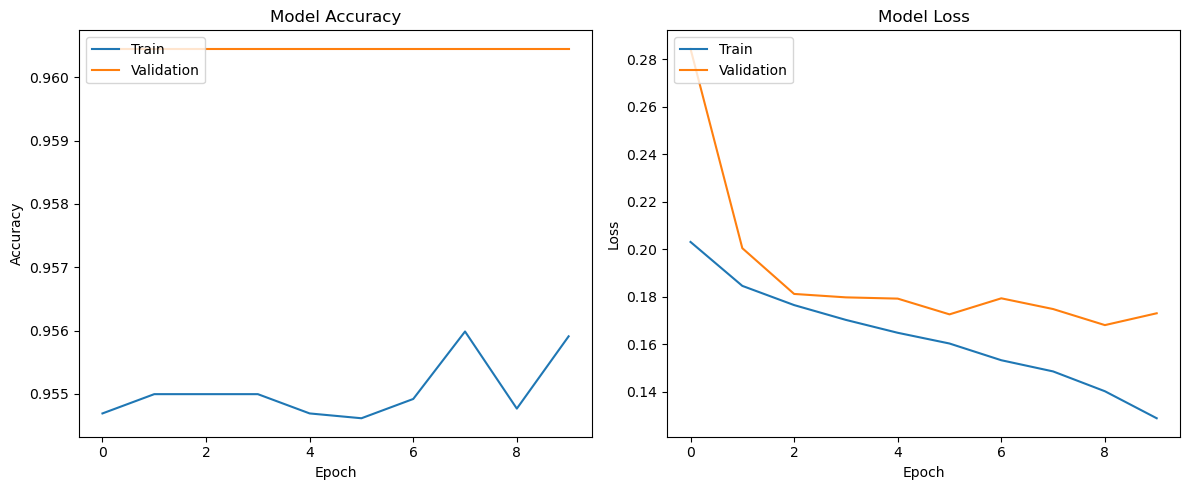

In [21]:
# Build model
embedding_shape = train_embeddings.shape[1:]  # (max_seq_len, embedding_dim)
feature_shape = X_train_features.shape[1]     # Number of additional features

model = build_lstm_model(embedding_shape, feature_shape)
print(model.summary())

# Train model
model, history = train_model(
    model, 
    train_embeddings, X_train_features, y_train, 
    val_embeddings, X_val_features, y_val, 
    loss
)

# Evaluate model
accuracy, macro_f1 = evaluate_model(model, test_embeddings, X_test_features, y_test, num_classes)

# Save model
model.save('lstm_text_classifier.h5')
print("Model saved as 'lstm_text_classifier.h5'")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
print("Training history plot saved as 'training_history.png'")